# AU 111 150 Ang cube gold substrate evaluation

## Initialization

In [285]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
import datetime, io, os, shutil, sys, tarfile
import os.path
from glob import glob
from pprint import pprint
from tabulate import tabulate
import numpy as np
import pandas as pd
import ruamel.yaml as yaml
import ase, ase.io
from ase.io import read, write
from ase.io import NetCDFTrajectory
#from asap3.analysis.rdf import RadialDistributionFunction

In [287]:
import matplotlib.pyplot as plt
from ase.visualize import view
from ase.visualize.plot import plot_atoms
import nglview as nv
import ipywidgets # just for jupyter notebooks
from IPython.display import Image, FileLink

In [288]:
from fireworks import Firework, Workflow
from fireworks import LaunchPad
from fireworks.utilities.filepad import FilePad 

import pymongo

In [5]:
fp = FilePad.auto_load()

In [6]:
 from sympy.ntheory.factor_ import factorint

In [289]:
# matplotlib settings

# expecially for presentation, larger font settings for plotting are recommendable
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc("font", size=MEDIUM_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (8,5) # the standard figure size

plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"]=1

In [150]:
from itertools import cycle
LINE_STYLES = ["-","--","-.",":"]

## Definitions

In [192]:
def download(content, mode='w+b', suffix='.lammps'):
    with tempfile.NamedTemporaryFile(mode=mode, suffix=suffix, dir=os.curdir) as fp:
        fp.write(content)
        full_name = fp.name
        prefix = os.getcwd()
        relative_name = os.path.relpath(full_name, prefix)
        display(FileLink(relative_name))
        input('Press enter to delete the file after you have downloaded it.')

In [32]:
def read_rdf(rdf_data, format='ovito', interval=None):
  """Reads rdf from input string into pandas.DataFrame

  Parameters
  ----------
  rdf_data: str
      input
  format: str
      'ovito' or 'plain'
  interval:
      overrides distances in file

  Returns
  -------
  pandas.Dataframe
      Data in 3-columns: bin index, corresponding distance and count
  """
  rdf_file = io.StringIO(rdf_data.decode())
  if format == 'ovito':
    # format is ovito 3.0.0-dev234 coordination analysis text output
    df = pd.read_csv(rdf_file,
      delim_whitespace=True,header=None,skiprows=3,index_col=0,
      names=['bin','distance','weight'])
  elif format == 'plain':
    df = pd.read_csv(rdf_file,
      delim_whitespace=True,header=None,skiprows=0,
      names=['distance','weight'])
    df.index.name = 'bin'

  if interval is not None:
    try:
      df.distance = np.linspace(interval[0],interval[1],df.shape[0]+1)[:-1]
    except:
      logger.exception(
        "Could not create grid points from specified interval {}".format(
          interval))
      raise ValueError()

  return df


In [33]:
# Creates four polar axes, and accesses them through the returned array
#fig, axes = plt.subplots(2, 2, subplot_kw=dict(polar=True))
def plotThermo(thermo, axes=None, legend=None, title=None):
    global line_list, label_list
    if axes is None:
        fig, axes = plt.subplots(5, 3, figsize=(20,20)) # constrained_layout=True)
        line_list = []
        label_list = []
    else:
        fig = axes[0,0].get_figure()
        
    l = axes[0, 0].plot(thermo["Step"], thermo["TotEng"])[0]
    axes[0, 1].plot(thermo["Step"], thermo["PotEng"])
    axes[0, 2].plot(thermo["Step"], thermo["KinEng"])

    axes[1, 0].plot(thermo["Step"], thermo["Temp"])
    axes[1, 1].plot(thermo["Step"], thermo["Press"])
    axes[1, 2].plot(thermo["Step"], thermo["Enthalpy"])

    axes[2, 0].plot(thermo["Step"], thermo["E_bond"])
    axes[2, 1].plot(thermo["Step"], thermo["E_angle"])
    axes[2, 2].plot(thermo["Step"], thermo["E_dihed"])

    axes[3, 0].plot(thermo["Step"], thermo["E_pair"])
    axes[3, 1].plot(thermo["Step"], thermo["E_vdwl"])
    axes[3, 2].plot(thermo["Step"], thermo["E_coul"])
    
    axes[4, 0].plot(thermo["Step"], thermo["E_long"])
    axes[4, 1].plot(thermo["Step"], thermo["Volume"])

    axes[0,0].set_title("Total Energy")
    axes[0,1].set_title("Potential Energy")
    axes[0,2].set_title("Kinetic Energy")

    axes[1,0].set_title("Temperature")
    axes[1,1].set_title("Pressure")
    axes[1,2].set_title("Enthalpy")

    axes[2, 0].set_title("E_bond")
    axes[2, 1].set_title("E_angle")
    axes[2, 2].set_title("E_dihed")

    axes[3, 0].set_title("E_pair")
    axes[3, 1].set_title("E_vdwl")
    axes[3, 2].set_title("E_coul")
    
    axes[4, 0].set_title("E_long")
    axes[4, 1].set_title("Volume")
    #axes[1, 1].scatter(x, y)

    axes[0,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[0,1].set_ylabel("$V$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[0,2].set_ylabel("$K$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")

    axes[1,0].set_ylabel("$T$ [ K ]")
    axes[1,1].set_ylabel("$P$ [ atm ]")
    axes[1,2].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")

    axes[2,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[2,1].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[2,2].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")

    axes[3,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[3,1].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[3,2].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    
    axes[4,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[4,1].set_ylabel("$V$ [ $ \mathrm{\AA^3} $ ]")
    #axes[4,1].set_visible(False)
    axes[4,2].set_visible(False)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if legend is not None:
        line_list.append(l)
        label_list.append(legend)
        fig.legend(line_list,label_list,loc="lower right", framealpha=1)
        
    if title is not None:
        fig.suptitle(title)
    
    return fig, axes

line_list = []
label_list = []

In [34]:
# plot function for 
# 'Step', 'TotEng', 'KinEng', 'PotEng', 'Temp', 'Press', 'Enthalpy',
#       'E_bond', 'E_angle', 'E_dihed', 'E_impro', 'E_pair', 'E_vdwl', 'E_coul',
#       'E_long', 'E_tail', 'Volume', 'Pxx', 'Pyy', 'Pzz', 'Pxy', 'Pxz', 'Pyz'
def plotThermoWithPressureTensor(thermo, axes=None, legend=None, title=None):
    global line_list, label_list
    if axes is None:
        fig, axes = plt.subplots(7, 3, figsize=(20,40)) # constrained_layout=True)
        line_list = []
        label_list = []
    else:
        fig = axes[0,0].get_figure()
    
    fig, axes = plotThermo(thermo, axes, legend, title)
    
    axes[5, 0].plot(thermo["Step"], thermo["Pxx"])
    axes[5, 1].plot(thermo["Step"], thermo["Pyy"])
    axes[5, 2].plot(thermo["Step"], thermo["Pzz"])
    
    axes[6, 0].plot(thermo["Step"], thermo["Pxy"])
    axes[6, 1].plot(thermo["Step"], thermo["Pyz"])
    axes[6, 2].plot(thermo["Step"], thermo["Pyz"])
    
    axes[5, 0].set_title("Pressure tensor component xx")
    axes[5, 1].set_title("Pressure tensor component yy")
    axes[5, 2].set_title("Pressure tensor component zz")

    axes[6, 0].set_title("Pressure tensor component xy")
    axes[6, 1].set_title("Pressure tensor component xz")
    axes[6, 2].set_title("Pressure tensor component yz")
    
    axes[5, 0].set_ylabel("$P_{xx}$ [ atm ]")
    axes[5, 1].set_ylabel("$P_{yy}$ [ atm ]")
    axes[5, 2].set_ylabel("$P_{zz}$ [ atm ]")
    
    axes[6, 0].set_ylabel("$P_{xy}$ [ atm ]")
    axes[6, 1].set_ylabel("$P_{xz}$ [ atm ]")
    axes[6, 2].set_ylabel("$P_{yz}$ [ atm ]")
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if legend is not None:
        fig.legend(line_list,label_list,loc="lower right", framealpha=1)
        
    if title is not None:
        fig.suptitle(title)
    
    return fig, axes

line_list = []
label_list = []

## Evaluation

### All system-related files

In [36]:
project_id = '2020-08-24-au-111-fcc-substrate-creation-trial'

In [37]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [38]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

85

In [39]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'step', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [40]:
res_df

,type,step,name,earliest,latest,object_count
0,thermo_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,NaN,2020-08-24 20:24:33.489028,2020-08-24 20:24:33.489028,1
1,fcc_rdf_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,NaN,2020-08-24 20:24:33.489024,2020-08-24 20:24:33.489024,1
2,rdf_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,NaN,2020-08-24 20:24:33.489020,2020-08-24 20:24:33.489020,1
3,box_measures_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,NaN,2020-08-24 20:24:33.489016,2020-08-24 20:24:33.489016,1
4,trajectory_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,NaN,2020-08-24 20:24:33.489012,2020-08-24 20:24:33.489012,1
5,thermo_ave_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,NaN,2020-08-24 20:24:33.489009,2020-08-24 20:24:33.489009,1
6,mass_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,NaN,2020-08-24 20:24:33.489005,2020-08-24 20:24:33.489005,1
7,log_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,NaN,2020-08-24 20:24:33.489001,2020-08-24 20:24:33.489001,1
8,input_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,NaN,2020-08-24 20:24:33.488997,2020-08-24 20:24:33.488997,1
9,index_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,NaN,2020-08-24 20:24:33.488993,2020-08-24 20:24:33.488993,1


### Thermo .out files overview

In [117]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'thermo_file',
}

In [118]:
# check files degenerate by 'metadata.type', 'metadata.name', 'metadata.step'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                #'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'step', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [119]:
res_df

,type,step,earliest,latest,object_count
0,thermo_file,LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisual...,2020-08-24 20:24:33.489028,2020-08-24 20:24:33.489028,1
1,thermo_file,LAMMPSEquilibrationNVT:ProcessAnalyzeAndVisual...,2020-08-24 20:24:33.488392,2020-08-24 20:24:33.488392,1
2,thermo_file,LAMMPSRelaxedBoxMinimization:ProcessAnalyzeAnd...,2020-08-24 17:48:58.998653,2020-08-24 20:24:33.487742,2
3,thermo_file,LAMMPSFixedBoxMinimization:ProcessAnalyzeAndVi...,2020-08-24 17:48:58.998020,2020-08-24 20:24:33.487054,2


In [120]:
print(res_df["step"].values)

['LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisualize:push_filepad'
 'LAMMPSEquilibrationNVT:ProcessAnalyzeAndVisualize:push_filepad'
 'LAMMPSRelaxedBoxMinimization:ProcessAnalyzeAndVisualize:push_filepad'
 'LAMMPSFixedBoxMinimization:ProcessAnalyzeAndVisualize:push_filepad']


### Thermo files evaluation

In [121]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'thermo_file',
    #'metadata.step': {'$regex':'LAMMPSFixedBoxMinimization'}
}

In [122]:
res_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'step': '$metadata.step',
            },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

thermoData = []
legend_pattern = "{step:s}"

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    legend = legend_pattern.format(step=metadata["metadata"]["step"])
    contStream = io.StringIO(content.decode())
    df = pd.read_csv(contStream,delim_whitespace=True)
    thermoData.append({'legend': legend, 'data': df})
    print('.',end='')
print('')

....


In [123]:
res_df = pd.concat([d["data"] for d in thermoData], keys=[d["legend"] for d in thermoData])

In [124]:
res_df

Step    TotEng  \
LAMMPSRelaxedBoxMinimization:ProcessAnalyzeAndV... 0        0 -17787064   
                                                   1       15 -17787622   
LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisuali... 0        0 -17437499   
                                                   1      100 -17436892   
                                                   2      200 -17435881   
...                                                       ...       ...   
LAMMPSEquilibrationNVT:ProcessAnalyzeAndVisuali... 96    9600 -17436604   
                                                   97    9700 -17436206   
                                                   98    9800 -17436807   
                                                   99    9900 -17436250   
                                                   100  10000 -17437499   

                                                           KinEng    PotEng  \
LAMMPSRelaxedBoxMinimization:ProcessAnalyzeAndV... 0         0.00 -17787064   
                                                   1         0.00 -17787622   
LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisuali... 0    174259.64 -17611759   
                                                   1    173919.15 -17610811   
                                                   2    174104.65 -17609986   
...                                                           ...       ...   
LAMMPSEquilibrationNVT:ProcessAnalyzeAndVisuali... 96   174611.25 -17611215   
                                                   97   175294.01 -17611500   
                                                   98   174626.83 -17611434   
                                                   99   175241.34 -17611491   
                                                   100  174259.64 -17611759   

                                                             Temp  \
LAMMPSRelaxedBoxMinimization:ProcessAnalyzeAndV... 0      0.00000   
                                                   1      0.00000   
LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisuali... 0    297.41960   
                                                   1    296.83846   
                                                   2    297.15506   
...                                                           ...   
LAMMPSEquilibrationNVT:ProcessAnalyzeAndVisuali... 96   298.01971   
                                                   97   299.18502   
                                                   98   298.04630   
                                                   99   299.09513   
                                                   100  297.41960   

                                                              Press  Enthalpy  \
LAMMPSRelaxedBoxMinimization:ProcessAnalyzeAndV... 0   -6381.756000 -18096545   
                                                   1       0.995953 -17787573   
LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisuali... 0    6488.960200 -17123951   
                                                   1   -1265.552800 -17498299   
                                                   2     407.047810 -17416147   
...                                                             ...       ...   
LAMMPSEquilibrationNVT:ProcessAnalyzeAndVisuali... 96   6535.097000 -17120826   
                                                   97   6533.172500 -17120521   
                                                   98   6549.790300 -17120319   
                                                   99   6524.146600 -17121001   
                                                   100  6488.960200 -17123951   

                                                        E_bond  E_angle  \
LAMMPSRelaxedBoxMinimization:ProcessAnalyzeAndV... 0         0        0   
                                                   1         0        0   
LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisuali... 0         0        0   
                                                   1         0        0   
                              

In [125]:
eq_df = res_df.loc[
    [
        "LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisualize:push_filepad", 
        "LAMMPSEquilibrationNVT:ProcessAnalyzeAndVisualize:push_filepad"]]

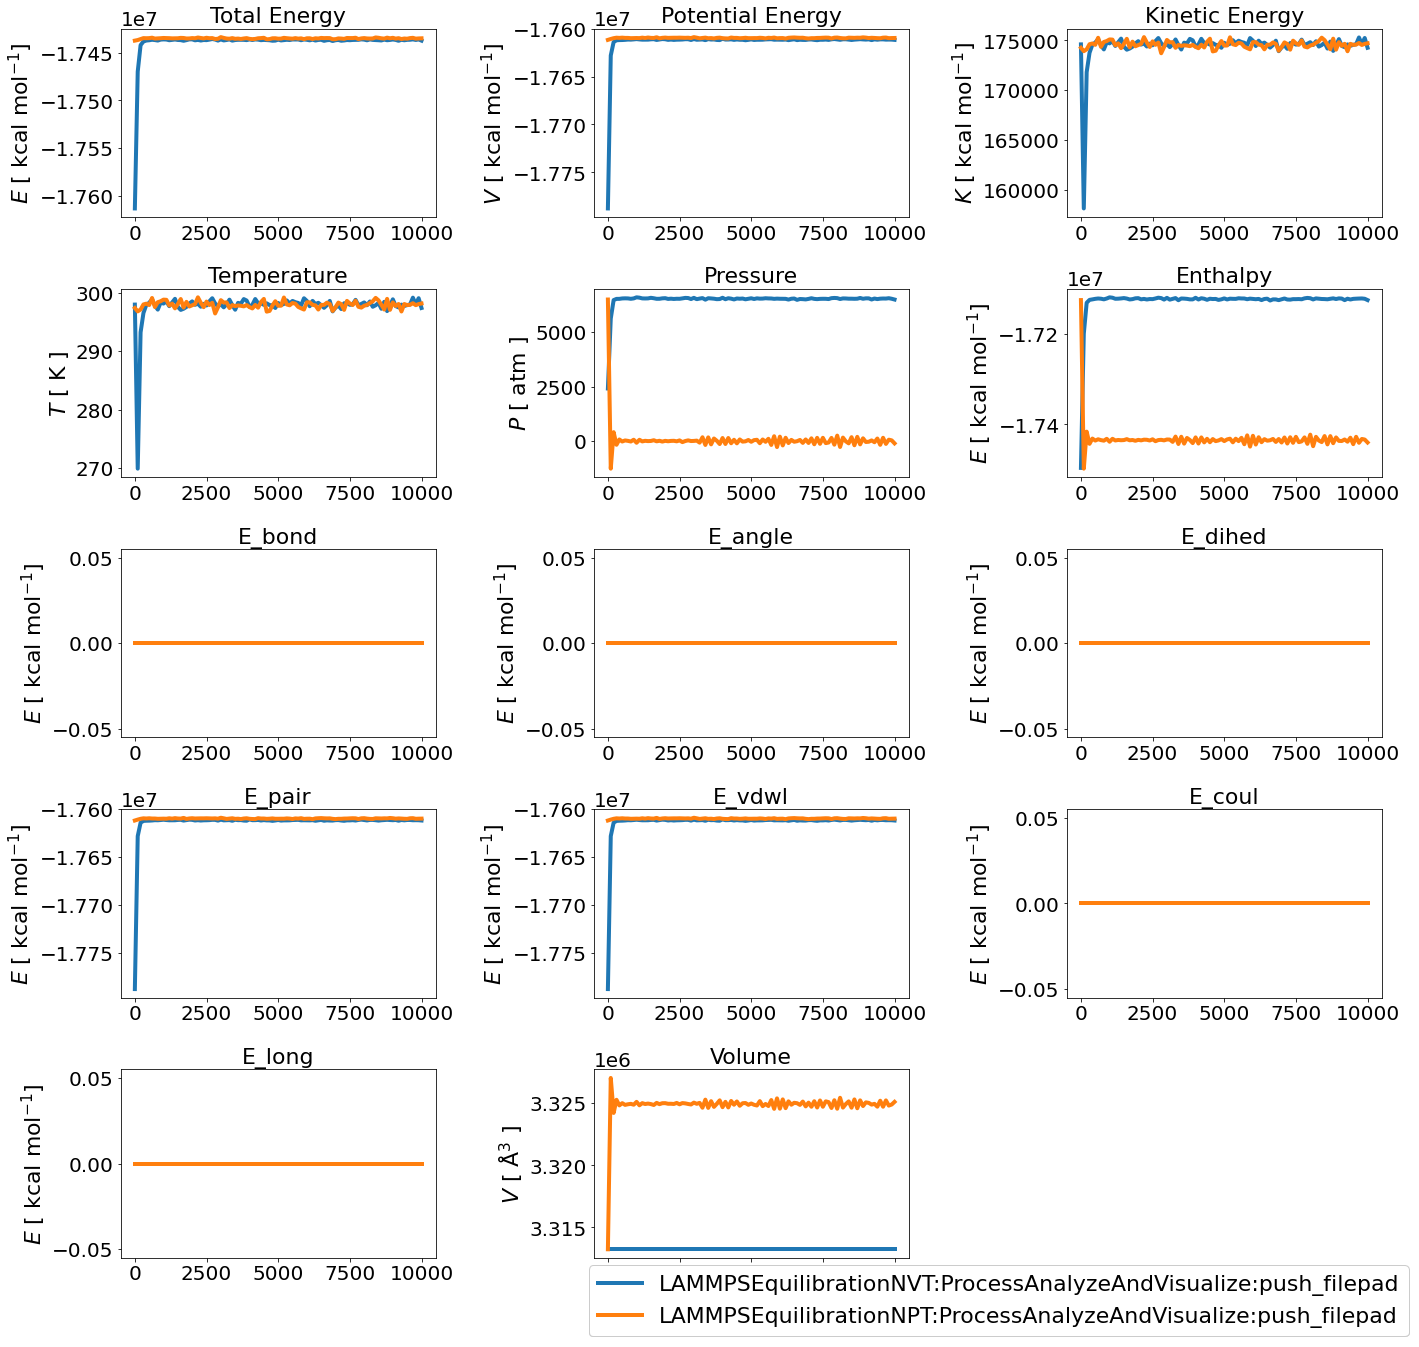

In [126]:
for i, step in enumerate(set(eq_df.index.get_level_values(0))):
    if i == 0:
        fig, ax = plotThermo(eq_df.loc[step], legend=step)
    else:
        fig, ax = plotThermo(eq_df.loc[step], axes=ax, legend=step)

### RDFs

In [127]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'rdf_file',
    'metadata.step': {'$regex':'Equilibration'}
}

In [142]:
res_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'step': '$metadata.step',
            },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

legends = []
rdf_data = []
legend_pattern = "{step:s}"

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    legends.append(legend_pattern.format(step=metadata["metadata"]["step"]))
    contStream = io.StringIO(content.decode())
    rdf_data.append(np.loadtxt(contStream).T)
    print('.',end='')
print('')

..


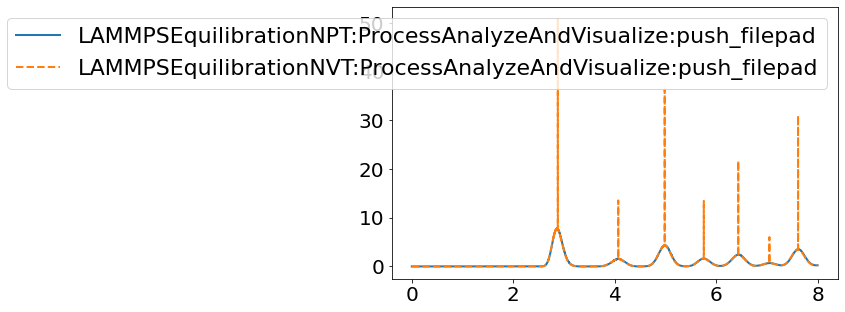

In [154]:
fig, ax = plt.subplots(1,1)
linecycler = cycle(LINE_STYLES)
for l, d in zip(legends, rdf_data):
    ax.plot(d[0], d[1], next(linecycler), label=l)
ax.legend()

### Datafile

In [159]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'data_file',
    'metadata.step': {'$regex':'EquilibrationNPT'}
}

In [170]:
res_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'step': '$metadata.step',
            },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)
dat = list(cursor)
print("#files: {}".format(len(dat)))

#files: 1


In [173]:
dat

[{'_id': {'type': 'data_file',
   'step': 'LAMMPSEquilibrationNPT:ProcessAnalyzeAndVisualize:push_filepad'},
  'degeneracy': 1,
  'latest': '5f443e5737559b23a31fbdfc'}]

In [174]:
content, metadata = fp.get_file_by_id(dat[0]["latest"])

In [191]:
with tempfile.NamedTemporaryFile(mode='w+b', suffix='.lammps', dir=os.curdir) as fp:
    fp.write(content)
    full_name = fp.name
    prefix = os.getcwd()
    relative_name = os.path.relpath(full_name, prefix)
    display(FileLink(relative_name))
    input('Press enter to delete the file after you have downloaded it.')

/mnt/dat/work/git/N_surfactant_on_substrate_template/ipynb/subst/tmpq_3rn4to.lammps
/mnt/dat/work/git/N_surfactant_on_substrate_template/ipynb/subst
tmpq_3rn4to.lammps


/mnt/dat/work/git/N_surfactant_on_substrate_template/ipynb/subst/tmpq_3rn4to.lammps

Press enter to delete the file after you have downloaded it.


In [193]:
import ase.io

In [205]:
stream = io.StringIO(content.decode())

In [202]:
lmp_data = ase.io.read(stream, format='lammps-data', )

In [204]:
lmp_data

Atoms(symbols='Na196560', pbc=True, cell=[149.8554557643805, 149.698841578054, 148.2229580276152], id=..., initial_charges=..., masses=..., mmcharges=..., mol-id=..., momenta=..., travel=..., type=...)

In [212]:
type_mapping = {11: ase.data.atomic_numbers['Au']}

In [213]:
 lmp_data = ase.io.lammpsdata.read_lammps_data(stream, Z_of_type=type_mapping, style='full', sort_by_id=False, units='real')

In [214]:
lmp_data

Atoms(symbols='Au196560', pbc=True, cell=[149.8554557643805, 149.698841578054, 148.2229580276152], id=..., initial_charges=..., masses=..., mmcharges=..., mol-id=..., momenta=..., travel=..., type=...)

In [218]:
ase.visualize.view(lmp_data)

In [224]:
lmp_data.cell.lengths()

array([149.85545576, 149.69884158, 148.22295803])

In [229]:
lmp_data.cell.min(axis=1)

array([0., 0., 0.])

In [231]:
with tempfile.NamedTemporaryFile(mode='w+b', suffix='.pdb', dir=os.path.curdir) as fp:
    full_name = fp.name
    ase.io.write(full_name, lmp_data, format="proteindatabank")
    prefix = os.getcwd()
    relative_name = os.path.relpath(full_name, prefix)
    display(FileLink(relative_name))
    input('Press enter to delete the file after you have downloaded it.')
# not ideal, looks like this:
# CRYST1  149.855  149.699  148.223  90.00  90.00  90.00 P 1
# MODEL     1
# ATOM      1   Au MOL     1     -71.122 -72.732 -70.656  1.00  0.00          AU  
# ATOM      2   Au MOL     1     -68.356 -72.732 -70.404  1.00  0.00          AU  
# ATOM      3   Au MOL     1     -72.567 -70.102 -70.545  1.00  0.00          AU  
# ATOM      4   Au MOL     1     -69.726 -70.198 -70.536  1.00  0.00          AU  

/mnt/dat/work/git/N_surfactant_on_substrate_template/ipynb/subst/tmpe_maj3t2.pdb

Press enter to delete the file after you have downloaded it.


In [232]:
import parmed as pmd

In [233]:
with tempfile.NamedTemporaryFile(mode='w+b', suffix='.xyz', dir=os.path.curdir) as fp:
    full_name = fp.name
    ase.io.write(full_name, lmp_data, format="xyz")
    prefix = os.getcwd()
    relative_name = os.path.relpath(full_name, prefix)
    display(FileLink(relative_name))
    input('Press enter to delete the file after you have downloaded it.')

/mnt/dat/work/git/N_surfactant_on_substrate_template/ipynb/subst/tmp29tc83rg.xyz

Press enter to delete the file after you have downloaded it.


In [235]:
import MDAnalysis
import MDAnalysis.coordinates

In [231]:
with tempfile.NamedTemporaryFile(mode='w+b', suffix='.pdb', dir=os.path.curdir) as fp:
    full_name = fp.name
    ase.io.write(full_name, lmp_data, format="proteindatabank")
    prefix = os.getcwd()
    relative_name = os.path.relpath(full_name, prefix)
    display(FileLink(relative_name))
    input('Press enter to delete the file after you have downloaded it.')
# not ideal, looks like this:
# CRYST1  149.855  149.699  148.223  90.00  90.00  90.00 P 1
# MODEL     1
# ATOM      1   Au MOL     1     -71.122 -72.732 -70.656  1.00  0.00          AU  
# ATOM      2   Au MOL     1     -68.356 -72.732 -70.404  1.00  0.00          AU  
# ATOM      3   Au MOL     1     -72.567 -70.102 -70.545  1.00  0.00          AU  
# ATOM      4   Au MOL     1     -69.726 -70.198 -70.536  1.00  0.00          AU  

/mnt/dat/work/git/N_surfactant_on_substrate_template/ipynb/subst/tmpe_maj3t2.pdb

Press enter to delete the file after you have downloaded it.


In [239]:
n_atoms = len(lmp_data)

In [244]:
len(content)

36927074

In [240]:
n_atoms

196560

In [248]:
mda_data = MDAnalysis.Universe.empty(n_atoms)

/usr/local/lib/python3.8/dist-packages/MDAnalysis/core/universe.py:467: UserWarning: Residues specified but no atom_resindex given.  All atoms will be placed in first Residue.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/MDAnalysis/core/universe.py:473: UserWarning: Segments specified but no segment_resindex given.  All residues will be placed in first Segment
  warnings.warn(


In [249]:
mda_data.

<Universe with 196560 atoms>

In [267]:
with tempfile.NamedTemporaryFile(mode='w+b', suffix='.lammps', dir=os.curdir) as fin, \
        tempfile.NamedTemporaryFile(mode='w+b', suffix='.pdb', dir=os.curdir) as fout:
    fin.write(content)
    full_name = fin.name
    lmp_data_reader = MDAnalysis.coordinates.LAMMPS.DATAReader(full_name, n_atoms=n_atoms)
    #print(lmp_data_reader.atom_style)
    lmp_data_writer = lmp_data_reader.Writer(fout.name, format='XYZ')

NotImplementedError: Sorry, there is no Writer for this format in MDAnalysis. Please file an enhancement request at https://github.com/MDAnalysis/mdanalysis/issues

In [255]:
type(lmp_data_reader)

MDAnalysis.coordinates.LAMMPS.DATAReader

In [280]:
pmd_data = pmd.Structure()
for i in range(n_atoms):
    atom = pmd.Atom(atomic_number=ase.data.atomic_numbers['Au'], name='AU')
    pmd_data.add_atom(atom,'AUM', i)

In [301]:
a

Atom('Au', [-64.06077773842748, 4.617942696840693, 70.61066619257792], momentum=[-1.4526608723606844, -1.1238911487038927, -1.3004274639222653], mass=196.96700005066864, charge=0.0, index=24504)

In [281]:
pmd_data.coordinates = lmp_data.get_positions()

In [ ]:
with tempfile.NamedTemporaryFile(mode='w+b', suffix='.pdb', dir=os.path.curdir) as fp:
    full_name = fp.name
    pmd_data.write_pdb(full_name)
    prefix = os.getcwd()
    relative_name = os.path.relpath(full_name, prefix)
    display(FileLink(relative_name))
    input('Press enter to delete the file after you have downloaded it.')

/mnt/dat/work/git/N_surfactant_on_substrate_template/ipynb/subst/tmp1zllvr3m.pdb

Press enter to delete the file after you have downloaded it.
